In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

class DiscreteSignal:
    color_cycle = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])
    def __init__(self, INF):
        self.INF = INF
        self.values = np.zeros(2 * INF + 1)
    def set_value_at_time(self, time, value):
       self.values[time + self.INF] = value    
    
    def get_value_at_time(self, time):
       return self.values[time + self.INF] 
    def shift_signal(self, shift):
        if abs(shift) > self.INF*2+1:
            self.values = np.zeros(2*self.INF+1)
            return
        if shift > 0:
            self.values = np.concatenate((np.zeros(shift), self.values[0:2*self.INF+1-shift]))
        elif shift < 0:
            self.values = np.concatenate((self.values[-shift:], np.zeros(-shift)))
    
    def add(self,other):
        signal2=DiscreteSignal(self.INF)
        signal2.values=self.values+other.values
        return signal2
    def multiply(self,other):
        signal2=DiscreteSignal(self.INF)
        signal2.values=self.values*other.values
        return signal2  
    def multiply_const_factor(self, scaler):
        signal2=DiscreteSignal(self.INF)
        signal2.values=self.values*scaler
        return signal2
    def plot(self, label='Signal'):
        time_points = np.arange(-self.INF, self.INF + 1, 1)
        color = next(DiscreteSignal.color_cycle)
        plt.stem(time_points, self.values, basefmt=" ", label=label, linefmt=color, markerfmt=color+'o')
        plt.xlabel('n (Time Index)')
        plt.ylabel('x[n]')
        plt.legend()
        plt.grid(True)
        # plt.show()
        # plt.figure()
        
    
        


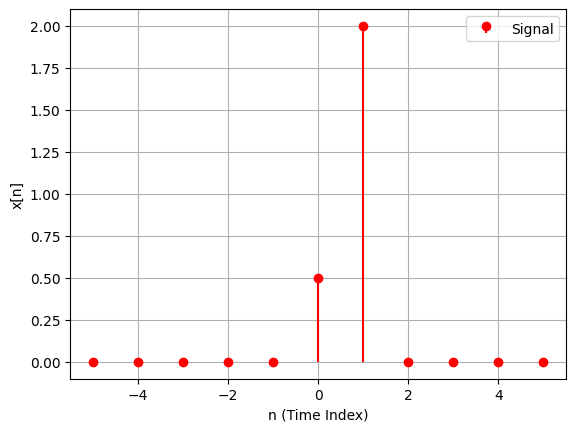

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

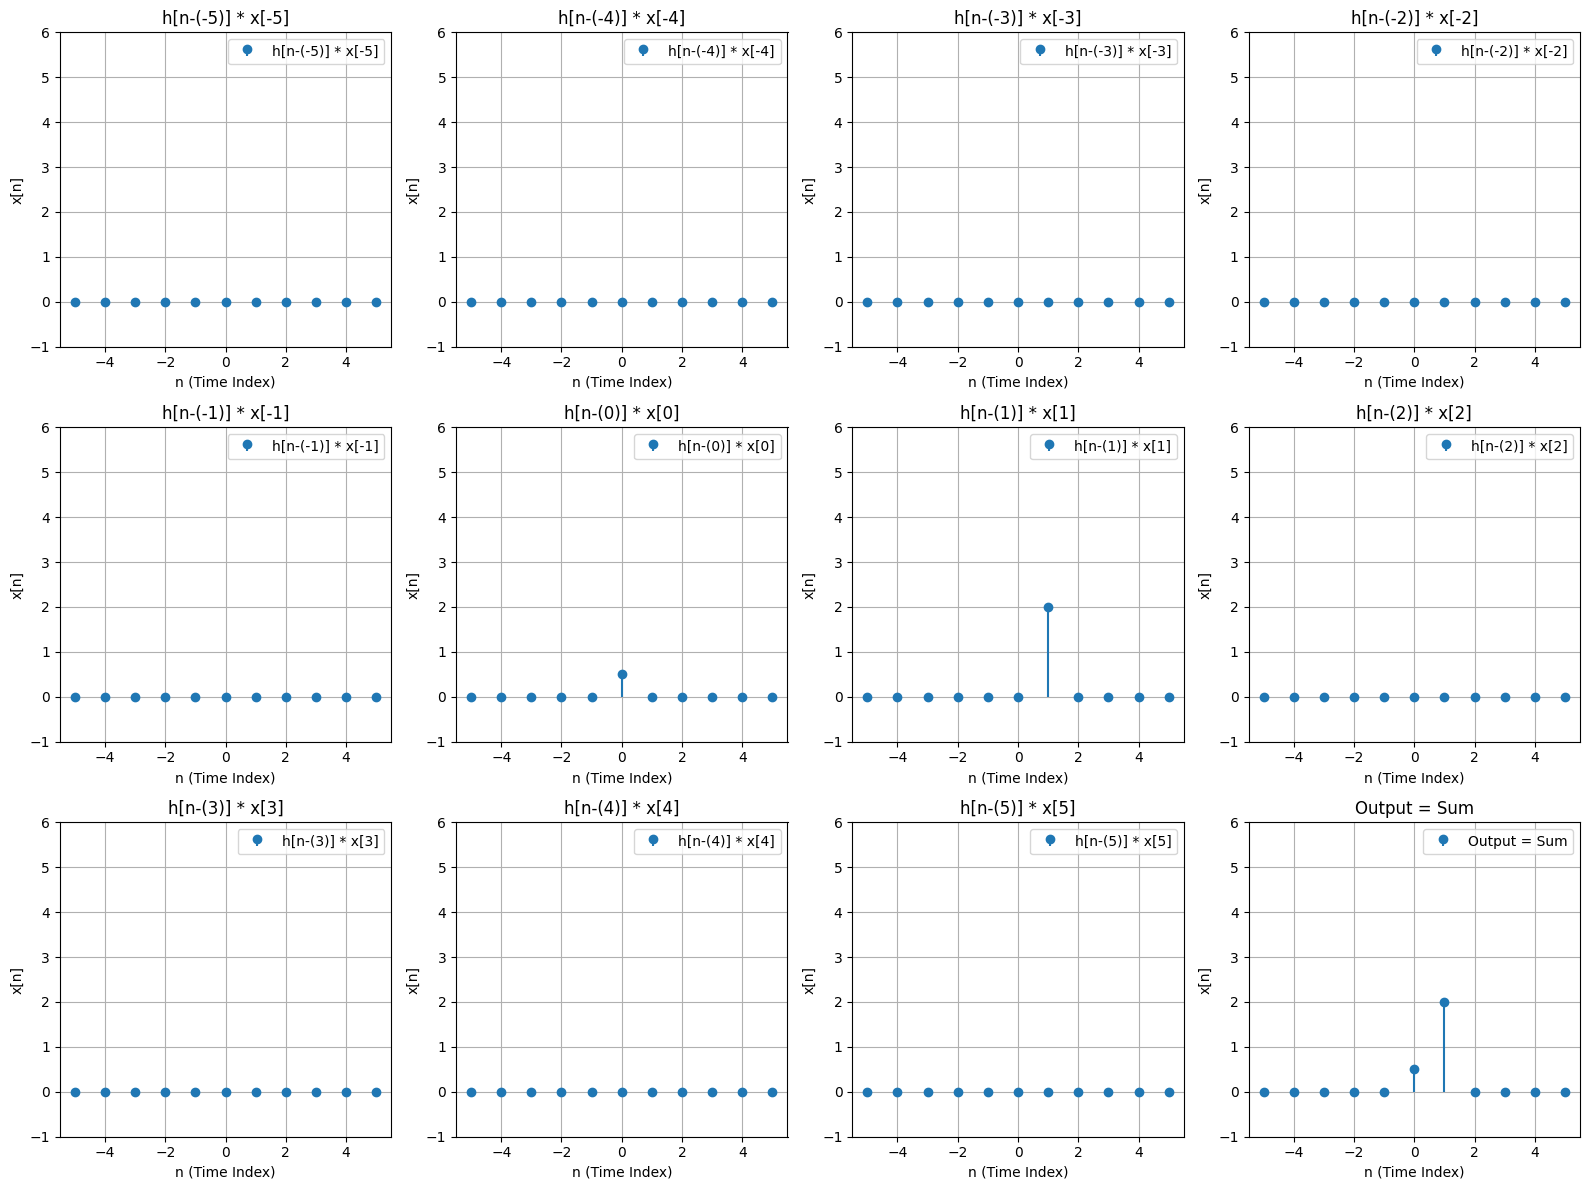

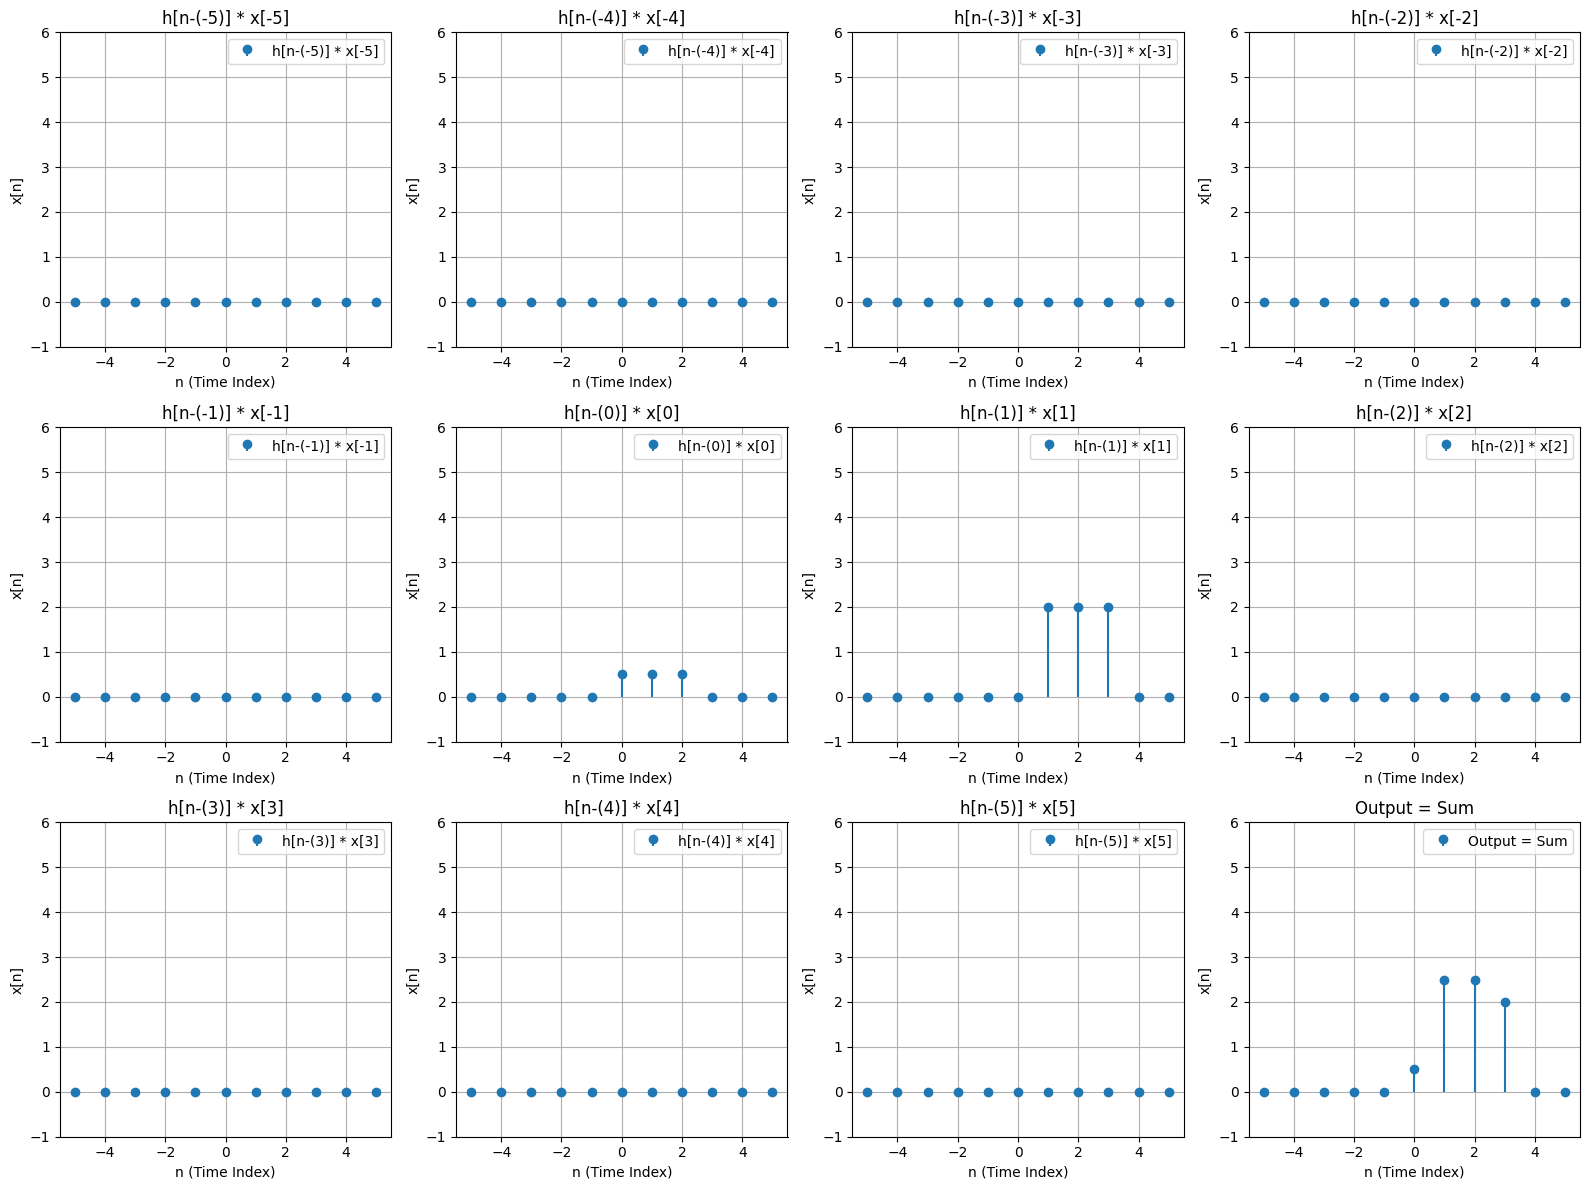

<Figure size 640x480 with 0 Axes>

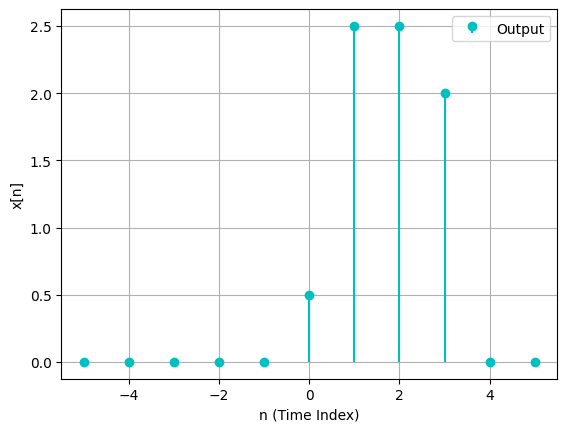

<Figure size 640x480 with 0 Axes>

In [30]:
class LTI_Discrete:
    def __init__(self, impulse_response):
        self.impulse_response = impulse_response
    
    def linear_combination_of_impulses(self, input_signal):
        decomposed = []
        components = []
        shifts=[]
        
        for i in range(-self.impulse_response.INF, self.impulse_response.INF + 1):
            coefficient = input_signal.get_value_at_time(i)
            
            # Create a shifted impulse where all values are initially 0
            shiftedImpulse = DiscreteSignal(self.impulse_response.INF)
                
            # Set value at t=0 to 1
            shiftedImpulse.set_value_at_time(0, 1)
                
            # Shift the signal by i amount
            shiftedImpulse.shift_signal(i)
                
            # Append the pair (shifted_unit_impulse, coeff) to decomposed
            decomposed.append((shiftedImpulse, coefficient, i))
            components.append(shiftedImpulse.multiply_const_factor(coefficient))
            shifts.append(i)
            scaled_impulse = shiftedImpulse.multiply_const_factor(coefficient)
            
        self.plot_components_subplots(components, shifts, input_signal,"input_signal_linear_combo")
                
        return decomposed
    
    def plot_components_subplots(self, components, shifts, final_output,fileName):
        num_components = len(components)
        num_rows = (num_components + 4 - 1) // 4  # Ensure space for final output
        fig, axs = plt.subplots(num_rows, 4, figsize=(16, 4 * num_rows))
        axs = axs.flatten()  # Flatten to handle indexing easily

        for idx, (component, time_shift) in enumerate(zip(components, shifts)):
            time_points = np.arange(-component.INF, component.INF + 1, 1)
            axs[idx].stem(time_points, component.values, basefmt=" ", label=f'h[n-({time_shift})] * x[{time_shift}]')
            axs[idx].set_title(f'h[n-({time_shift})] * x[{time_shift}]')
            axs[idx].set_xlabel('n (Time Index)')
            axs[idx].set_ylabel('x[n]')
            axs[idx].set_ylim(-1, 6)  # Set y-axis limits from -1 to 6
            axs[idx].legend()
            axs[idx].grid(True)

        # Plot the final output (sum) in the next subplot
        time_points = np.arange(-final_output.INF, final_output.INF + 1, 1)
        axs[num_components].stem(time_points, final_output.values, basefmt=" ", label='Output = Sum')
        axs[num_components].set_title('Output = Sum')
        axs[num_components].set_xlabel('n (Time Index)')
        axs[num_components].set_ylabel('x[n]')
        axs[num_components].set_ylim(-1, 6)  # Set y-axis limits from -1 to 6
        axs[num_components].legend()
        axs[num_components].grid(True)

        # Hide any unused subplots
        for j in range(num_components + 1, len(axs)):
            axs[j].axis('off')

        plt.tight_layout()
        if not os.path.exists("discrete_plots"):
            os.makedirs("discrete_plots")
        plt.savefig(f"discrete_plots/{fileName}.png")
        plt.show()

    def output(self, signal):
        result = DiscreteSignal(self.impulse_response.INF)
        decomposed = self.linear_combination_of_impulses(signal)

        components = []
        shifts = []
        
        for decomposed_signal, coefficient, i in decomposed:
            shifted_response = DiscreteSignal(self.impulse_response.INF)
            shifted_response.values = self.impulse_response.values
            shifted_response.shift_signal(i)
            
            component = shifted_response.multiply_const_factor(coefficient)
            components.append(component)
            shifts.append(i)
            
            result = result.add(component)

        # Plot all components in a grid with 4 columns per row and include final output (sum)
        self.plot_components_subplots(components, shifts, result,"final_output")
        
        return result

    def show(self):
        self.impulse_response.plot("Impulse Response")

INF = 5

impulse_response = DiscreteSignal(INF)
impulse_response.set_value_at_time(0, 1)
impulse_response.set_value_at_time(1, 1)
impulse_response.set_value_at_time(2, 1)

input_signal = DiscreteSignal(INF)
input_signal.set_value_at_time(0, 0.5)
input_signal.set_value_at_time(1, 2)

input_signal.plot()
plt.figure()

systemDemo = LTI_Discrete(impulse_response)
# systemDemo.linear_combination_of_impulses(input_signal)
plt.figure()
output = systemDemo.output(input_signal)
output.plot("Output")
plt.figure()


In [ ]:
# Main function to generate subplots and save figures

def main():
    # Set up the impulse response and input signal
    INF = 5
    impulse_response = DiscreteSignal(INF)
    impulse_response.set_value_at_time(0, 1)
    impulse_response.set_value_at_time(1, 1)
    impulse_response.set_value_at_time(2, 1)
    
    input_signal = DiscreteSignal(INF)
    input_signal.set_value_at_time(0, 0.5)
    input_signal.set_value_at_time(1, 2)

    # Initialize the LTI system
    lti_system = LTI_Discrete(impulse_response)
    
    # Plot the input signal
    plt.figure()
    input_signal.plot("")
    plt.title("Input Discrete Signal, INF=5")
    plt.savefig("discrete_plots/input_signal.png")


# Run the main function
main()
